Libraries

In [2]:
import numpy as np
# from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import tqdm as tqdm
from scipy.integrate import odeint

Solving SIR Model Numerically

In [3]:
def SIR(x, t, N, beta, gamma):
    S, I, R = x
    xdot = [
        -(beta*S*I)/N,
        (beta*S*I)/N - gamma*I,
        gamma*I
    ]
    return xdot

In [13]:
# Total population, N.
N = 100
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Initial state of the system
X0 = [S0, I0, R0]

# Parameters
beta, gamma = 1.5, 0.5

# A grid of time points (in days)
finalT = 17.0
t  = np.linspace(0, finalT, 100)

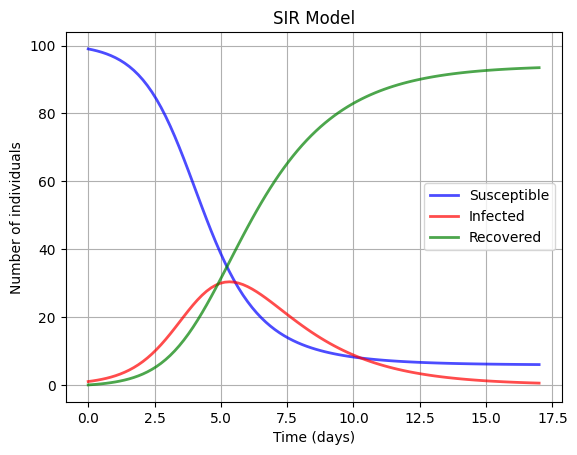

In [14]:
# Integrate the SIR equations over the time grid, t.
result = odeint(SIR, X0, t, args=(N, beta, gamma))
S, I, R = result.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
plt.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
plt.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
plt.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
plt.xlabel('Time (days)')
plt.ylabel('Number of individuals')
plt.title('SIR Model')
plt.legend()
plt.grid(True)
plt.show()

Generating Observational Data

In [31]:
random_indices = np.random.choice(len(t), size=15, replace=False)

S_obs = [S[ind] for ind in random_indices]
I_obs = [I[ind] for ind in random_indices]
R_obs = [R[ind] for ind in random_indices]

# Generate Gaussian noise for S_obs, I_obs, and R_obs
noise_S = 0.04 * np.random.randn(len(S_obs))
noise_I = 0.04 * np.random.randn(len(I_obs))
noise_R = 0.04 * np.random.randn(len(R_obs))

# Add the noise to the observed values
S_obs_noise = [S_obs[ind] + noise_S[ind] for ind in range(len(S_obs))]
I_obs_noise = [I_obs[ind] + noise_I[ind] for ind in range(len(I_obs))]
R_obs_noise = [R_obs[ind] + noise_R[ind] for ind in range(len(R_obs))]

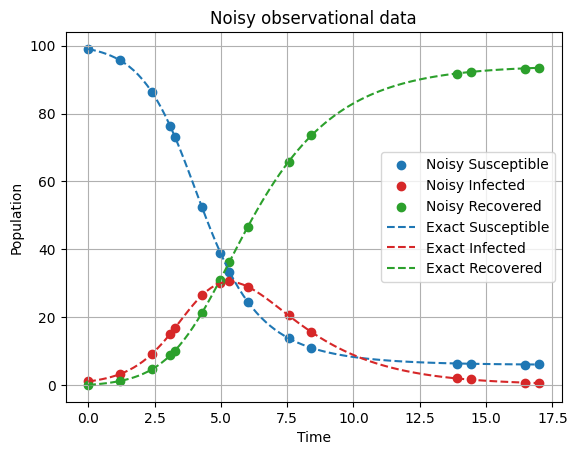

In [32]:
plt.figure()
plt.title("Noisy observational data")
plt.scatter([t[ind] for ind in random_indices], S_obs_noise, label='Noisy Susceptible', color="tab:blue")
plt.scatter([t[ind] for ind in random_indices], I_obs_noise, label='Noisy Infected', color="tab:red")
plt.scatter([t[ind] for ind in random_indices], R_obs_noise, label='Noisy Recovered', color="tab:green")
plt.plot(t, S, label='Exact Susceptible', color="tab:blue", linestyle='--')
plt.plot(t, I, label='Exact Infected', color="tab:red", linestyle='--')
plt.plot(t, R, label='Exact Recovered', color="tab:green", linestyle='--')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.grid(True)
plt.show()


Tensors

In [33]:
t_obs = torch.tensor([t[ind] for ind in random_indices], dtype=torch.float32).view(-1,1)
u_obs_S = torch.tensor(S_obs_noise,  dtype=torch.float32).view(-1,1)
u_obs_I = torch.tensor(I_obs_noise,  dtype=torch.float32).view(-1,1)
u_obs_R = torch.tensor(R_obs_noise,  dtype=torch.float32).view(-1,1)

In [39]:
# Create approx. 10 equally spaced points for training 
t_physics = []
for i in range(len(t)):
    if i % 10 == 0:
        t_physics.append(t[i])
t_physics = torch.tensor(t_physics, dtype=torch.float32).view(-1,1).requires_grad_(True)

print(len(t_physics))

10


In [44]:
# Create 30 approximately equally spaced points for testing
indices = [i for i in range(100) if i % 3 == 0]
t_test = torch.tensor([t[i] for i in indices], dtype=torch.float32).view(-1, 1)
u_test_S = torch.tensor([S[i] for i in indices], dtype=torch.float32).view(-1, 1)
u_test_I = torch.tensor([I[i] for i in indices], dtype=torch.float32).view(-1, 1)
u_test_R = torch.tensor([R[i] for i in indices], dtype=torch.float32).view(-1, 1)

34


Defining the network

In [46]:
class FCN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce_S = nn.Linear(N_HIDDEN, N_OUTPUT)
        self.fce_I = nn.Linear(N_HIDDEN, N_OUTPUT)
        self.fce_R = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        S_output = self.fce_S(x)
        I_output = self.fce_I(x)
        R_output = self.fce_R(x)
        return S_output, I_output, R_output

Training

  0%|          | 0/30000 [00:00<?, ?it/s]

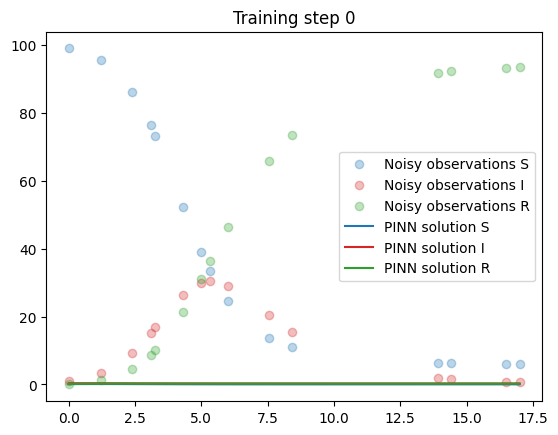

 13%|█▎        | 3995/30000 [00:22<02:20, 185.19it/s]

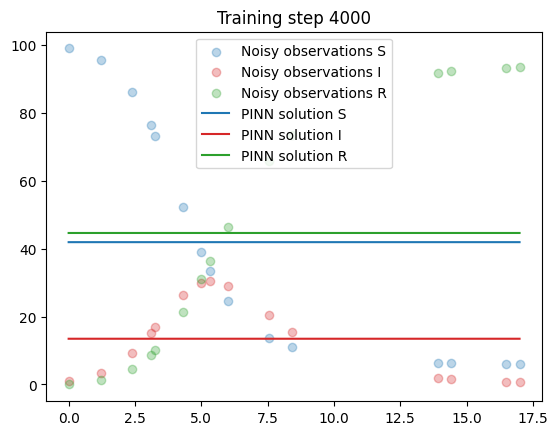

 27%|██▋       | 7984/30000 [00:43<02:17, 160.08it/s]

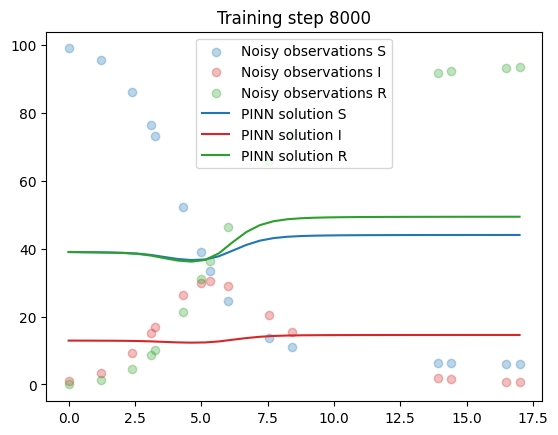

 40%|███▉      | 11985/30000 [01:03<01:29, 201.06it/s]

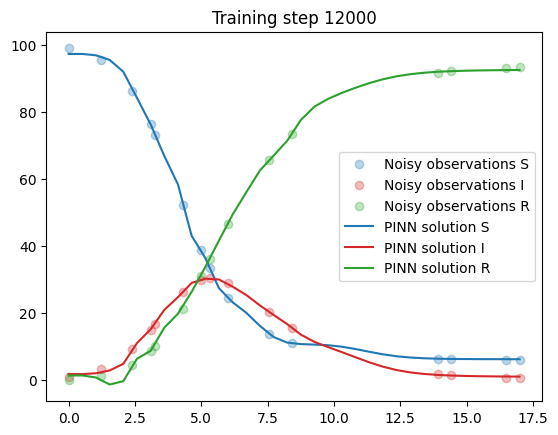

 53%|█████▎    | 15994/30000 [01:21<00:58, 239.42it/s]

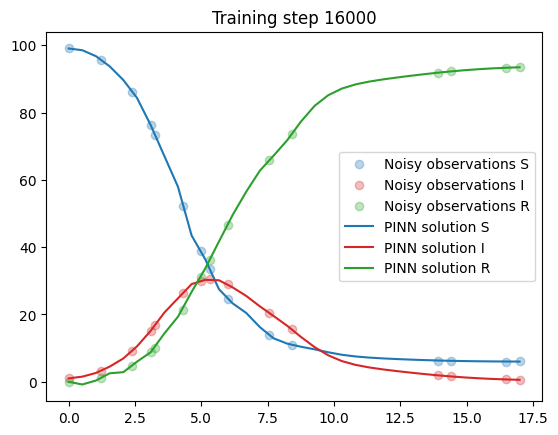

 67%|██████▋   | 19989/30000 [01:39<00:42, 236.77it/s]

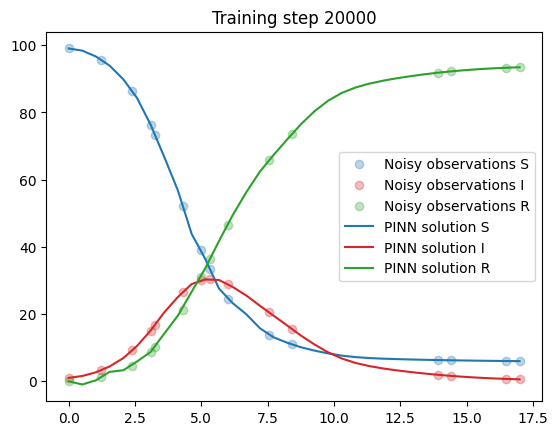

 80%|███████▉  | 23982/30000 [01:58<00:27, 221.44it/s]

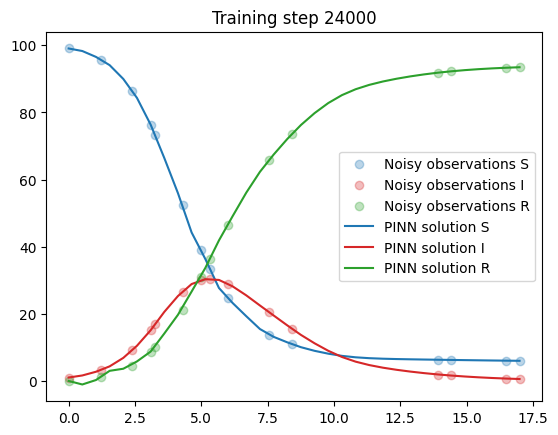

 93%|█████████▎| 27985/30000 [02:17<00:08, 234.21it/s]

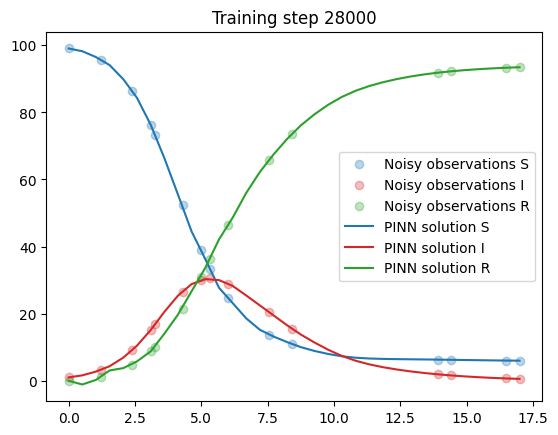

100%|██████████| 30000/30000 [02:28<00:00, 202.63it/s]


In [49]:
pinn = FCN(1,1,32,3)

# Initialize lists to store loss values
physics_loss_values = []
data_loss_values = []
total_loss_values = []

# LEARNABLE PARAMS
beta = torch.nn.Parameter(torch.zeros(1, requires_grad=True))
betas = []
gamma = torch.nn.Parameter(torch.zeros(1, requires_grad=True))
gammas = []

optimiser = torch.optim.Adam(list(pinn.parameters())+[beta,gamma],lr=1e-3)


for i in tqdm.tqdm(range(30000)):
    optimiser.zero_grad()

    # Hyperparameter
    lambda1 = 1e4

    # -----------------------
    #       PHYSICS LOSS
    # -----------------------
    uS, uI, uR = pinn(t_physics)

    # Compute the derivatives with respect to time
    duSdt = torch.autograd.grad(uS, t_physics, torch.ones_like(uS), create_graph=True)[0]
    duIdt = torch.autograd.grad(uI, t_physics, torch.ones_like(uI), create_graph=True)[0]
    duRdt = torch.autograd.grad(uR, t_physics, torch.ones_like(uR), create_graph=True)[0]

    # Compute the physics loss for SIR equations
    phy_loss_S = torch.mean((duSdt + (beta * uS * uI) / N) ** 2)
    phy_loss_I = torch.mean((duIdt - (beta * uS * uI) / N + gamma * uI) ** 2)
    phy_loss_R = torch.mean((duRdt - gamma * uI) ** 2)

    total_physics_loss = phy_loss_S + phy_loss_I + phy_loss_R

    # -----------------------
    #       DATA LOSS
    # -----------------------
    # Compute the PINN output
    uS, uI, uR = pinn(t_obs)
    data_loss_S = torch.mean((uS - u_obs_S)**2)
    data_loss_I = torch.mean((uI - u_obs_I)**2)
    data_loss_R = torch.mean((uR - u_obs_R)**2)

    total_data_loss = data_loss_S + data_loss_I + data_loss_R

    # Backpropagate joint loss, take optimiser step
    loss = total_physics_loss + lambda1*total_data_loss
    loss.backward()
    optimiser.step()

    # Append loss values to lists
    physics_loss_values.append(total_physics_loss.item())
    data_loss_values.append(total_data_loss.item())
    total_loss_values.append(loss.item())

    # Keep track of parameter values
    betas.append(beta.item())
    gammas.append(gamma.item())

    # plot the result as training progresses
    if i % 4000 == 0: 
        uS, uI, uR = pinn(t_test)
        with torch.no_grad():
            plt.scatter(t_obs, u_obs_S, label="Noisy observations S", alpha=0.3, color="tab:blue")
            plt.scatter(t_obs, u_obs_I, label="Noisy observations I", alpha=0.3, color="tab:red")
            plt.scatter(t_obs, u_obs_R, label="Noisy observations R", alpha=0.3, color="tab:green")
            plt.plot(t_test, uS, label="PINN solution S", color="tab:blue")
            plt.plot(t_test, uI, label="PINN solution I", color="tab:red")  
            plt.plot(t_test, uR, label="PINN solution R", color="tab:green")  
            plt.title(f"Training step {i}")
            plt.legend()
            plt.show()


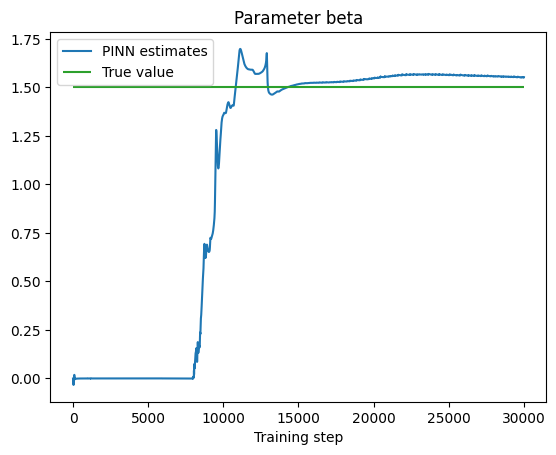

In [50]:
plt.figure()
plt.title("Parameter beta")
plt.plot(betas, label="PINN estimates")
plt.hlines(1.5, 0, len(betas), label="True value", color="tab:green")
plt.legend()
plt.xlabel("Training step")
plt.show()

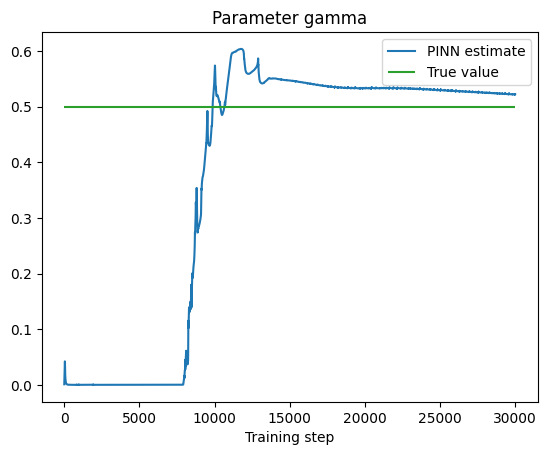

In [51]:
plt.figure()
plt.title("Parameter gamma")
plt.plot(gammas, label="PINN estimate")
plt.hlines(0.5, 0, len(gammas), label="True value", color="tab:green")
plt.legend()
plt.xlabel("Training step")
plt.show()